# Preprocessing

### Importing libraries and datasets

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cleaning_functions as cf 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score


In [2]:
combined_file_path = '../data/cleaned/winequality_combined_cleaned.csv' 
combined_df = pd.read_csv(combined_file_path)
combined_df

,wine_type_red,wine_type_white,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,1,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,1,0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,1,0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,1,0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,1,0,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,0,1,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
5316,0,1,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
5317,0,1,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
5318,0,1,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [24]:
#Defining function to streamline linear regression process
def linear_regression(X_train, X_test, y_train, y_test):
    #Linear regression
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    print(f'model coefficients:\n {model.coef_}\n')
    print(f'model intercept:\n {model.intercept_}\n')
    #Applying model to X test
    y_pred = pd.DataFrame(model.predict(X_test))
    
    #Resetting index of y test
    y_test = y_test.reset_index(drop=True)

    #Creating combined table with y_test and y_pred
    residuals_df = pd.concat([y_test, y_pred], axis=1)
    # Get the current column names as a list
    column_names = residuals_df.columns.tolist()
    # Use the rename method to rename columns using column names list
    residuals_df = residuals_df.rename(columns={column_names[0]: "y_test", column_names[1]: "y_pred"}) 
    #Calculating residuals
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]

   #Root mean squared error
    rmse = mse(y_test,y_pred, squared = False)
    print(f'Root mean squared error: {rmse} \n')

    #R^2
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2} \n')

    #Calculating adjusted R^2
    n = X_train.shape[0]  # Number of observations
    p = X_train.shape[1]  # Number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R2: {adjusted_r2} \n')

    return model.coef_

### Distributions

<Figure size 1500x1500 with 0 Axes>

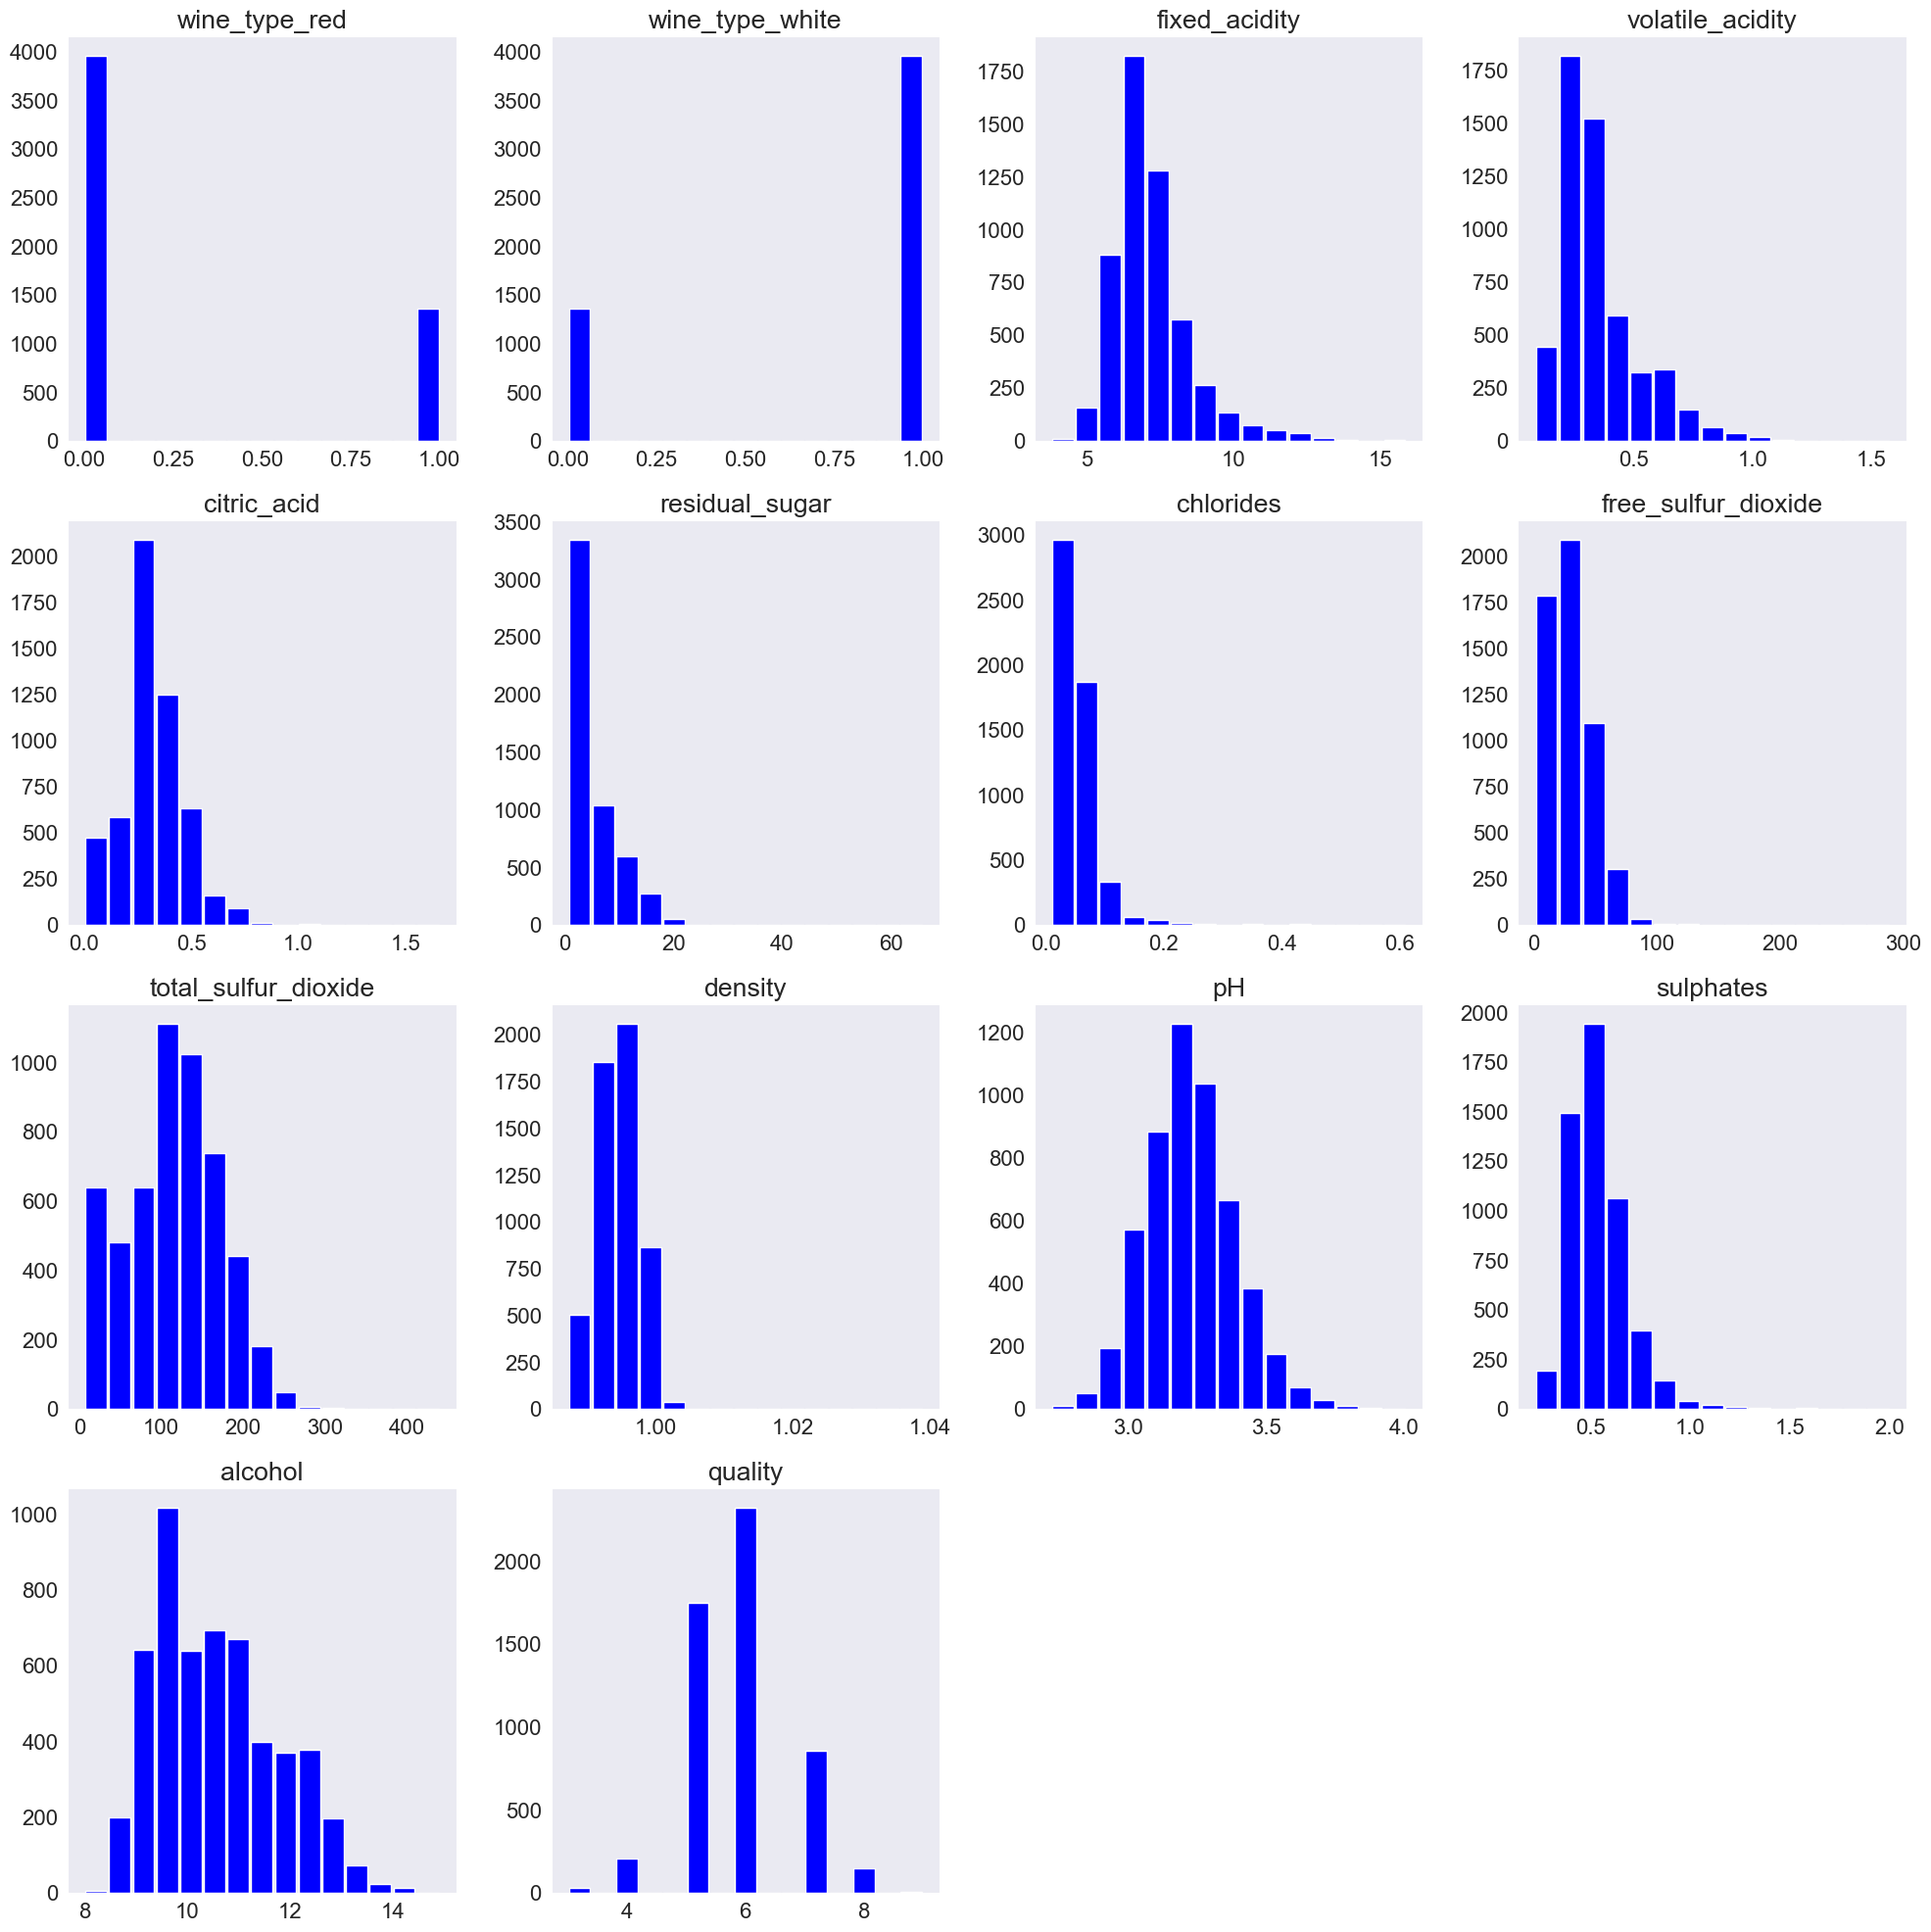

In [25]:
plt.figure(figsize=(15, 15))
combined_df.hist(bins=15, grid=False, figsize=(20, 20), color='blue', zorder=2, rwidth=0.9)
plt.tight_layout()
plt.rcParams.update({'font.size': 16})
plt.show()

### Splitting data into X and y

In [43]:
#define X and Y
X = combined_df.drop(['quality'], axis=1)
y = pd.DataFrame(combined_df["quality"])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

### Linear Regression Model - no scalers or transforms

In [44]:
linear_regression(X_train, X_test, y_train, y_test)

model coefficients:
 [[ 1.25505243e-01 -1.25505243e-01  5.14233787e-02 -1.30653384e+00
   1.69091969e-01  4.70769160e-02 -1.08573990e+00  5.81039945e-03
  -1.81066398e-03 -8.03971041e+01  4.74662450e-01  8.31836571e-01
   2.47358841e-01]]

model intercept:
 [81.11261535]

Root mean squared error: 0.723044654854994 

R2: 0.3149956658951406 

Adjusted R2: 0.31275596359550195 



array([[ 1.25505243e-01, -1.25505243e-01,  5.14233787e-02,
        -1.30653384e+00,  1.69091969e-01,  4.70769160e-02,
        -1.08573990e+00,  5.81039945e-03, -1.81066398e-03,
        -8.03971041e+01,  4.74662450e-01,  8.31836571e-01,
         2.47358841e-01]])

### PowerTransformer on X

In [45]:
#Power Transform
pt = PowerTransformer(method='yeo-johnson')
pt.fit(X_train)
X_train_p = pd.DataFrame(pt.transform(X_train))
X_test_p= pd.DataFrame(pt.transform(X_test))


### PowerTransformer on y

In [48]:
pt_y = PowerTransformer(method='yeo-johnson')
pt_y.fit(y_train)
y_train_p = pd.DataFrame(pt_y.transform(y_train))
y_test_p = pd.DataFrame(pt_y.transform(y_test))

In [ ]:
#Standard scaler
standard_scaler = StandardScaler()
#Standardizing X_train_f
standard_scaler_f.fit(X_train_f)
X_train_f_s = pd.DataFrame(standard_scaler_f.transform(X_train_f))
#Standardizing X_test *** ensuring to use same scaler from X_train
X_test_f_s = pd.DataFrame(standard_scaler_f.transform(X_test_f))


### Standard Scaler on y

### Linear Regression Model - power transform on X

In [53]:
coefficients = linear_regression(X_train_p, X_test_p, y_train_p, y_test_p)

model coefficients:
 [[-8.54240590e+11 -8.54240590e+11 -3.14452440e-02 -2.16783621e-01
   5.90174906e-02  1.07436686e-01 -9.78281911e-02  2.01563225e-01
  -1.83196689e-01 -1.60464862e+09  1.58127835e-02  1.20087703e-01
   4.21757913e-01]]

model intercept:
 [-1.31853578e-09]



KeyError: 'y_test'

In [52]:
#getting feature names and coefficients
feature_names = list(X_train.columns)
#coefficients = [i for i in coefficients[0]]

#creating feature importance dataframe
fi_dict = {"name":feature_names,"coeff":coefficients}
fi_df = pd.DataFrame(fi_dict)
fi_df = fi_df.sort_values('coeff', ascending=False)

#Getting absolute values
fi_df_abs = fi_df['coeff'] = fi_df['coeff'].abs() 
#Sorting in descending order
fi_df_abs = fi_df.sort_values('coeff', ascending=False)

ValueError: Per-column arrays must each be 1-dimensional

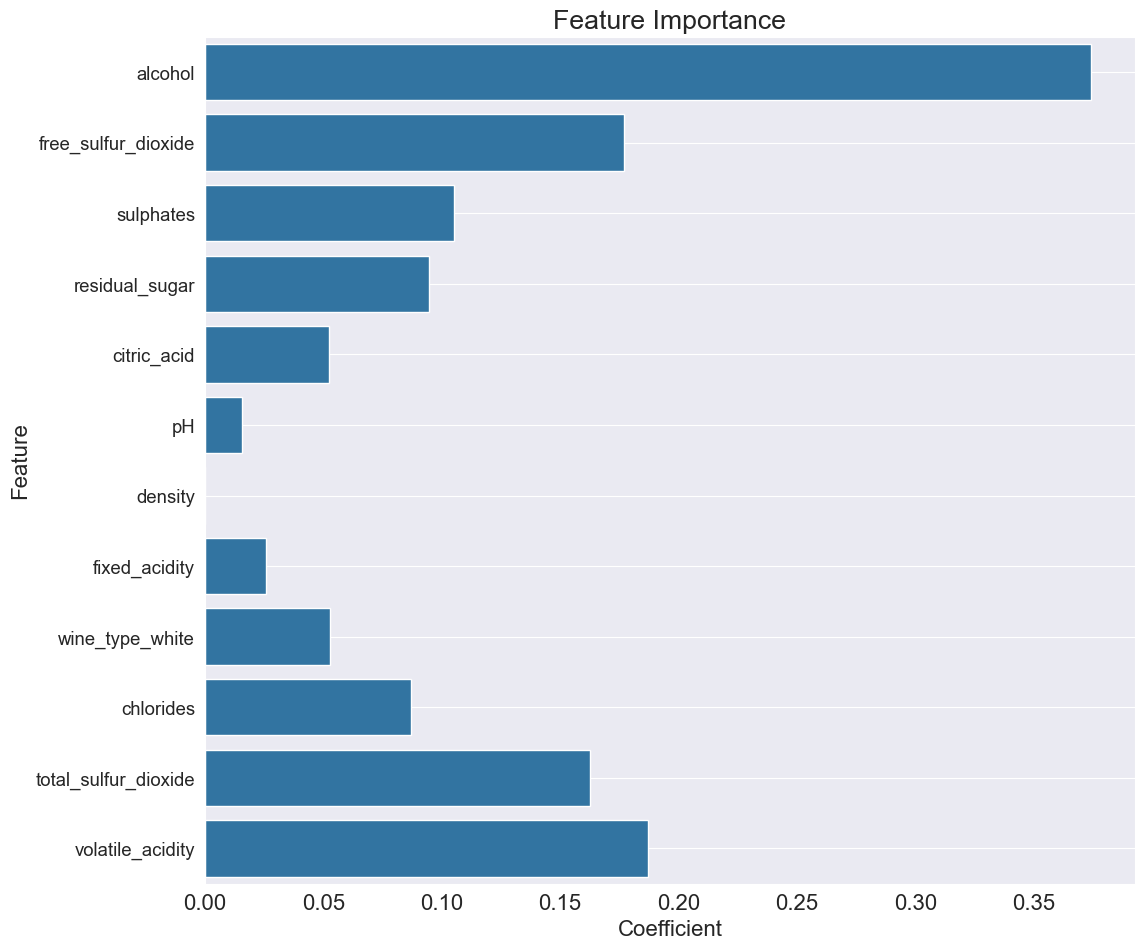

In [31]:
#Feature importance plot for standardized data
plt.figure(figsize=(12, 11))
sns.set_style("darkgrid")
sns.barplot(y="name", x="coeff", data=fi_df)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid()
plt.xticks()
plt.yticks(fontsize='small')
plt.show()